In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. 計算関数の定義 ---

def compute_aa_and_aia(acc_matrix: list[list[float]]) -> tuple[list[float], list[float]]:
    """AA_kとAIA_kをそれぞれ計算する。"""
    AA_list = []
    AIA_list = []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs) / len(current_accs)
        AA_list.append(AA_k)
        AIA_k = sum(AA_list) / len(AA_list)
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix: list[list[float]]) -> list[float]:
    """Forgetting Measure (FM_k) を計算する。"""
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []
        
    fm_list = [0.0]  # Task 0 終了時点では忘却は発生しないので0
    
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            # Task j に対する過去の最高精度を計算 (l < k)
            past_accs_on_j = [acc_matrix[l][j] for l in range(j, k)]
            max_past_acc = max(past_accs_on_j)
            
            # 現在のTask jに対する精度
            current_acc = acc_matrix[k][j]
            
            # 忘却量を計算し、合計に加える
            forgetting_sum += (max_past_acc - current_acc)
            
        # Task k 終了時点での平均忘却量を計算
        avg_forgetting = forgetting_sum / k
        fm_list.append(avg_forgetting)
        
    return fm_list

def compute_im(acc_matrix: list[list[float]], joint_accs: list[float]) -> list[float]:
    """
    Intransigence Measure (IM_k) を計算する
    """
    num_tasks = len(acc_matrix)
    im_list = []

    for k in range(num_tasks):
        if k >= len(joint_accs):
            break
        a_k_star = joint_accs[k]         # 合同学習精度
        a_k_k = acc_matrix[k][k]         # 継続学習でタスクk学習直後の精度
        im_list.append(a_k_star - a_k_k) # 差を計算

    return im_list

# --- 2. 設定 ---

csv_directory = "/work/csv/uci-har/dil_ex/"
csv_directory_im = "/work/csv/uci-har/dil-ex/im/"
models_to_process = {
    "RNN": "rnn.csv",
    "CNN": "cnn.csv",
    "LSTM": "lstm.csv",
    "NCPS": "ltc_ncps.csv"
}
tasks = [
    (0,-1.0),
    (1,-1.0),
    (2,-1.0),
    (3,-1.0),
    (4,-1.0),
    (5,-1.0),
    (6,-1.0)
]
num_tasks = len(tasks)
color_palette = {
    "CNN": "blue",
    "RNN": "green",
    "LSTM": "orange",
    "NCPS": "red"
}

# --- 3. データ処理と全指標の計算 ---

all_metrics_results = []
for model_name, file_name in models_to_process.items():
    file_path = os.path.join(csv_directory, file_name)
    if not os.path.exists(file_path):
        print(f"警告: ファイルが見つかりません: {file_path}")
        continue
        
    print(f"\n--- Processing model: {model_name} ---")
    df = pd.read_csv(file_path)
    accuracies = df['テスト精度 (Test Acc)'].tolist()
    
    acc_matrix = []

    # im用
    joint_file_path = os.path.join(csv_directory_im, file_name)
    if not os.path.exists(joint_file_path):
        print(f"警告: Jointファイルが見つかりません: {joint_file_path}")
        continue
    joint_df = pd.read_csv(joint_file_path)
    joint_accuracies = joint_df['テスト精度 (Test Acc)'].tolist()

    current_pos = 0
    for k in range(num_tasks):
        num_evals = k + 1
        if current_pos + num_evals > len(accuracies):
            print(f"エラー: {model_name} のデータ数が不足しています。")
            break
        row = accuracies[current_pos : current_pos + num_evals]
        acc_matrix.append(row)
        current_pos += num_evals

    if not acc_matrix:
        continue

    # AA, AIA, FM, IM を計算
    aa_list, aia_list = compute_aa_and_aia(acc_matrix)
    fm_list = compute_fm(acc_matrix)
    im_list = compute_im(acc_matrix, joint_accuracies)
    
    for k in range(len(aa_list)):
        all_metrics_results.append({
            "Model": model_name,
            "Task": k,
            "AA": aa_list[k],
            "AIA": aia_list[k],
            "FM": fm_list[k],
            "IM": im_list[k],
            "Task 0 Acc": acc_matrix[k][0] 
        })

metrics_df = pd.DataFrame(all_metrics_results)
print("\n--- Calculated Metrics (AA, AIA, FM, IM) ---")
print(metrics_df)


--- Processing model: RNN ---

--- Processing model: CNN ---

--- Processing model: LSTM ---

--- Processing model: NCPS ---

--- Calculated Metrics (AA, AIA, FM, IM) ---
   Model  Task        AA       AIA        FM        IM  Task 0 Acc
0    RNN     0  0.899286  0.899286  0.000000 -0.240000    0.899286
1    RNN     1  0.568214  0.733750  0.609643 -0.028510    0.289643
2    RNN     2  0.665000  0.710833  0.309286 -0.016932    0.307143
3    RNN     3  0.593214  0.681429  0.323333  0.092697    0.140000
4    RNN     4  0.627500  0.670643  0.199018  0.226546    0.578571
5    RNN     5  0.639048  0.665377  0.163357  0.100398    0.702500
6    RNN     6  0.519439  0.644529  0.200833  0.512670    0.553571
7    CNN     0  0.906071  0.906071  0.000000 -0.288929    0.906071
8    CNN     1  0.628036  0.767054  0.514286 -0.124631    0.391786
9    CNN     2  0.720119  0.751409  0.240000 -0.086591    0.597143
10   CNN     3  0.620625  0.718713  0.299405  0.030850    0.370357
11   CNN     4  0.607571

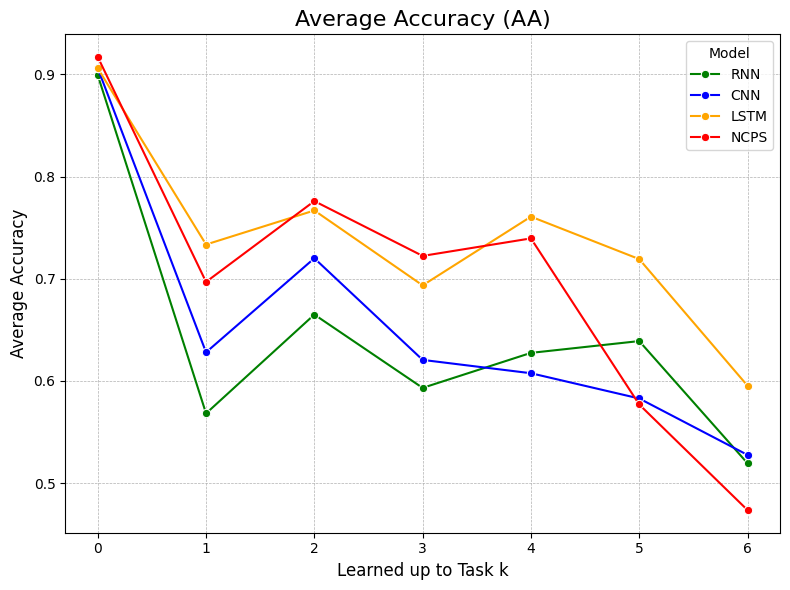

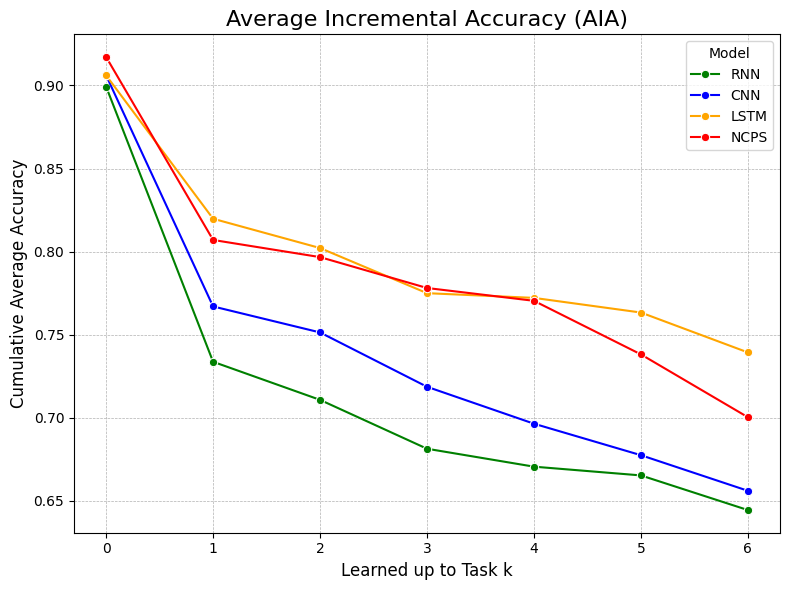

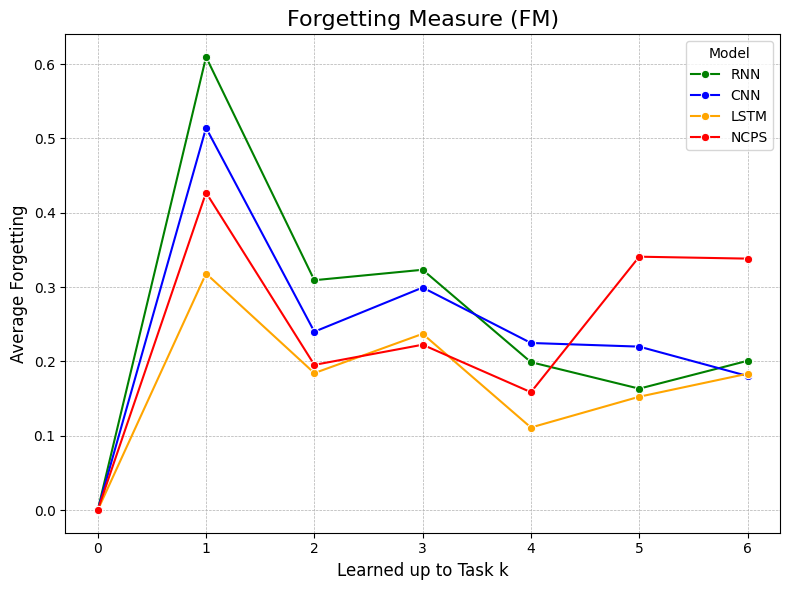

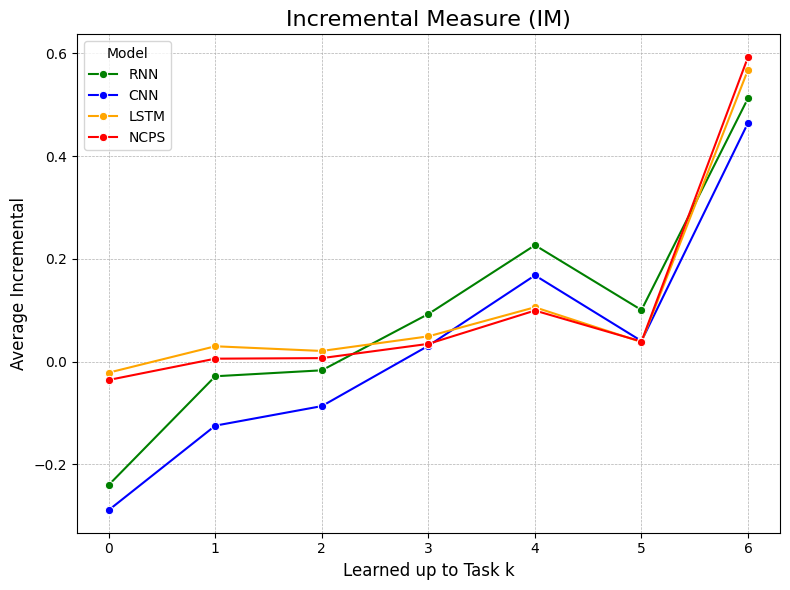

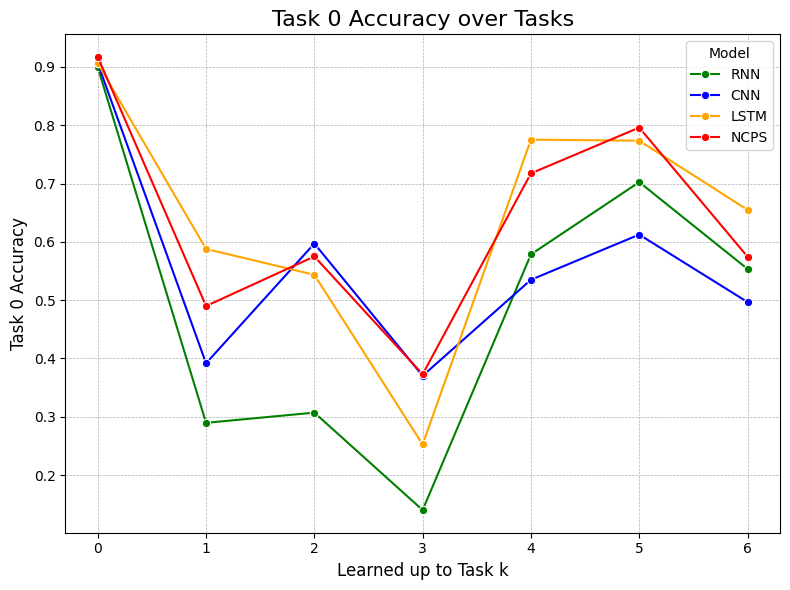

In [5]:

# --- AA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="AA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Accuracy (AA)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.xticks(range(num_tasks))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- AIA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="AIA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Incremental Accuracy (AIA)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Cumulative Average Accuracy", fontsize=12)
plt.xticks(range(num_tasks))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- FM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="FM", hue="Model", palette=color_palette, marker="o")
plt.title("Forgetting Measure (FM)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Average Forgetting", fontsize=12)
plt.xticks(range(num_tasks))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- IM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="IM", hue="Model", palette=color_palette, marker="o")
plt.title("Incremental Measure (IM)", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Average Incremental", fontsize=12)
plt.xticks(range(num_tasks))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- Task 0 Acc ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Task", y="Task 0 Acc", hue="Model", palette=color_palette, marker="o")
plt.title("Task 0 Accuracy over Tasks", fontsize=16)
plt.xlabel("Learned up to Task k", fontsize=12)
plt.ylabel("Task 0 Accuracy", fontsize=12)
plt.xticks(range(num_tasks))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()